In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
from model import *
%matplotlib inline
import pickle

In [4]:
x = 5+5

In [8]:
print('the number x is: ' + str(x))

the number x is: 10


In [2]:
sns.set_context('talk')
sns.set_palette('deep')

In [3]:
model_names = ["HNN","HNN_dhdt","HNN_dhdt_energy","HNN","HNN_dhdt_VI","HNN_VI","HNN_dhdt_nowdecay"]

In [8]:
data_dir = "expt_29_sept/"

In [9]:
HNN = torch.load(data_dir+"HNN")
HNN.eval()
HNN_dhdt = torch.load(data_dir+"HNN_dhdt")
HNN_dhdt.eval()
HNN_dhdt_energy = torch.load(data_dir+"HNN_dhdt_energy")
HNN_dhdt_energy.eval()
HNN_dhdt_VI = torch.load(data_dir+"HNN_dhdt_VI")
HNN_dhdt_VI.eval()
HNN_VI = torch.load(data_dir+"HNN_VI")
HNN_VI.eval()

HNN_VI(
  (mlp1): Linear(in_features=3, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=1, bias=True)
)

In [10]:
HNN_now = torch.load(data_dir+"HNN_dhdt_nowdecay")
HNN_now.eval()

HNN(
  (mlp1): Linear(in_features=3, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=1, bias=True)
)

In [11]:
model_dict = {"HNN_now":HNN_now,"HNN":HNN,"HNN_dhdt":HNN_dhdt,"HNN_dhdt_energy":HNN_dhdt_energy,"HNN_dhdt_VI":HNN_dhdt_VI,"HNN_VI":HNN_VI}

In [12]:
n_test_traj = 1
num_nodes = 2
T_max_t = 30.05
dt = 0.05
srate = 0.05
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
valid_data = pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=int(T_max_t//srate), num_workers=2, shuffle=False)


In [30]:

def yoshida4(dx_dt_fn, x_t, t):
    dt = 0.05
    
    w0 = -(2**(1/3))/(2-2**(1/3))
    w1 = 1/(2-2**(1/3))
    c1 = c4 = w1/2
    c2 = c3 = (w0+w1)/2
    d1 = d3 = w1
    d2 = w0
    
    
    
    q = x_t[0,0]
    p = x_t[0,1]
    
    q1 = q + c1*dt*p
    p1 = p + dt*d1*(dx_dt_fn(torch.cat([q1.reshape(1,1), p.reshape(1,1)],1), t))[0][1]
    q2 = q1 + c2*dt*p1
    p2 = p1 + dt*d2*(dx_dt_fn(torch.cat([q2.reshape(1,1), p1.reshape(1,1)],1), t))[0][1]
    q3 = q2 + c3*dt*p2
    p3 = p2 + dt*d3*(dx_dt_fn(torch.cat([q3.reshape(1,1), p2.reshape(1,1)],1), t))[0][1]
    
    
    q_next = q3 + c4*dt*p3
    p_next = p3
    
    return torch.cat([q_next.reshape(1,1), p_next.reshape(1,1)],1)



def symp_euler(dx_dt_fn, x_t, t):
    dt = 0.05
    q = x_t[0,0]
    p = x_t[0,1]
    
    q_next = q + dt*(dx_dt_fn(x_t,t))[0][0]
    p_next = p + dt*(dx_dt_fn(torch.cat([q_next.reshape(1,1), p.reshape(1,1)],1), t))[0][1]
    
    return torch.cat([q_next.reshape(1,1), p_next.reshape(1,1)],1)


def VI(dx_dt_fn, x_t, t):
    dt = 0.05
    q = x_t[0,0]
    p = x_t[0,1]
    dUdq = (dx_dt_fn(x_t, t))[0][1]
    qddot = dUdq
    q_next = q + dt * p + 0.5 * (dt ** 2) * qddot
    dUdq_next = (dx_dt_fn(torch.cat([q_next.reshape(1,1), p.reshape(1,1)],1), t))[0][1]
    dUdq_mid = dUdq + dUdq_next
    qddot_mid = dUdq_mid
    p_next = p + 0.5 * dt * qddot_mid

    return torch.cat([q_next.reshape(1,1), p_next.reshape(1,1)],1)


def get_model_results_VI(model):
    energies = []
    mabs = []
    for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(val_dataloader):
        q, q_next, qdx = q.float(), q_next.float(), qdx.float()
        q.to(device)
        q_next.to(device)
        energy_.to(device)
        qdx.to(device)
        tevals = tevals.float()
        tevals.to(device)
        loss = 0
        q.requires_grad = True
        tevals.requires_grad = True
        #print(tevals)
        preds = []
        pred_ham = []
        qinit = q[0].reshape(1, -1)
                
        
        for i in range(len(q_next)):
            next_step_pred = VI(model.time_deriv,qinit,tevals[i])
            pred_ham.append(model.get_H(torch.cat([qinit,tevals[i].reshape(-1,1)],1)))
            preds.append(next_step_pred)
            qinit = next_step_pred

        pred_ham = torch.cat(pred_ham).detach().numpy()
        preds = torch.cat(preds).detach().numpy()
        q_next = q_next.detach().numpy()

        energies.append(pred_ham)
        mabs.append(np.mean(np.square(preds-q_next),1))
        
    return [energies,mabs,preds,q_next]

In [31]:
model_results = {}
model_results["HNN_now"] = get_model_results_VI(HNN_now)
# model_results["HNN_dhdt_VI"] = get_model_results_VI(HNN_dhdt_VI)

In [12]:
model_results = {}
for key,value in model_dict.items():
    model_results[key]= get_model_results(value)


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [29]:
# def edrift(hnn_e):
#     avg_energy_drift = []
#     for i in range(n_test_traj):
#         energy_drift = np.abs(hnn_e[i] - hnn_e[i][0])
#         avg_energy_drift.append(energy_drift)
#     avg_energy_drift = np.array(avg_energy_drift).mean(0)
#     return avg_energy_drift

Text(0, 0.5, 'MSE')

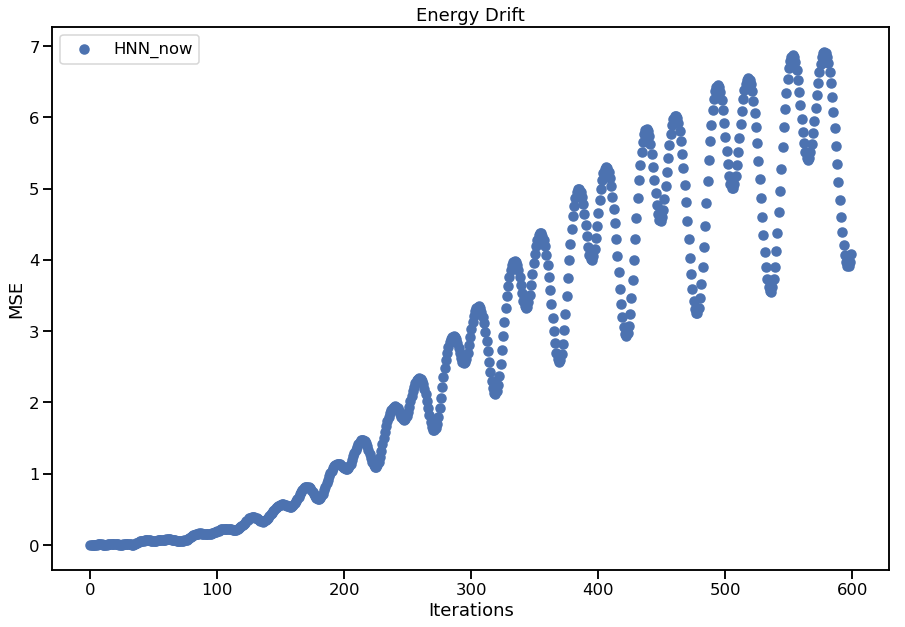

In [32]:
plt.figure(figsize=(15,10))
for key in model_results.keys():
    energies = model_results[key][0]
    energy_drift = np.abs(energies[0] - energies[0][0])
    plt.scatter(x=range(int(T_max_t//srate)),y=energy_drift,label=key)
plt.legend()
plt.title('Energy Drift')
plt.xlabel('Iterations')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

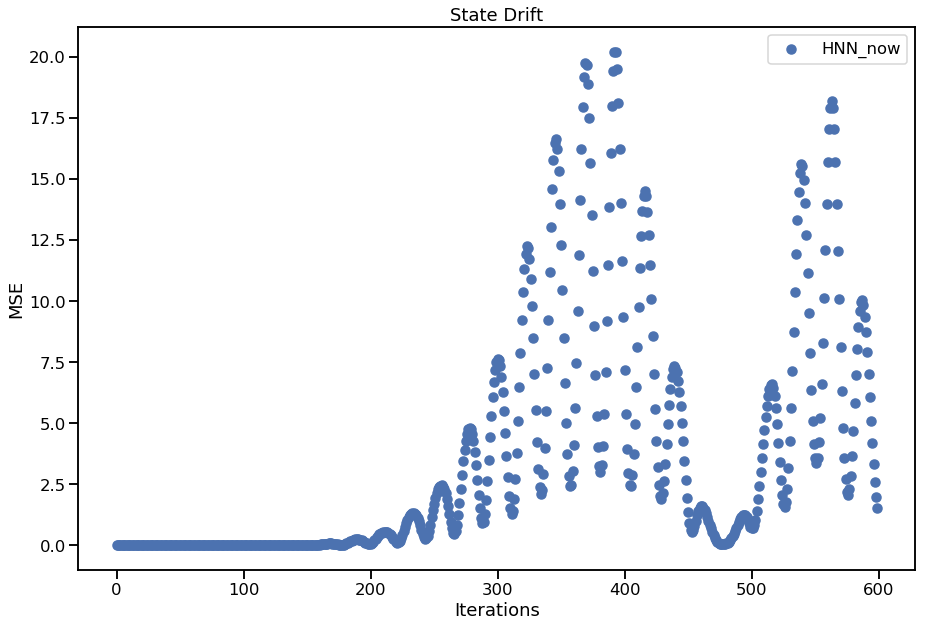

In [33]:
plt.figure(figsize=(15,10))
for key in model_results.keys():
    preds = model_results[key][2]
    actual = model_results[key][3]
    yvals = np.mean(np.square(preds-actual),1)
    plt.scatter(x=range(int(T_max_t//srate)),y=yvals,label=key)
plt.legend()
plt.title('State Drift')
plt.xlabel('Iterations')
# plt.xscale('log')
plt.ylabel('MSE')

Text(0, 0.5, '$p$')

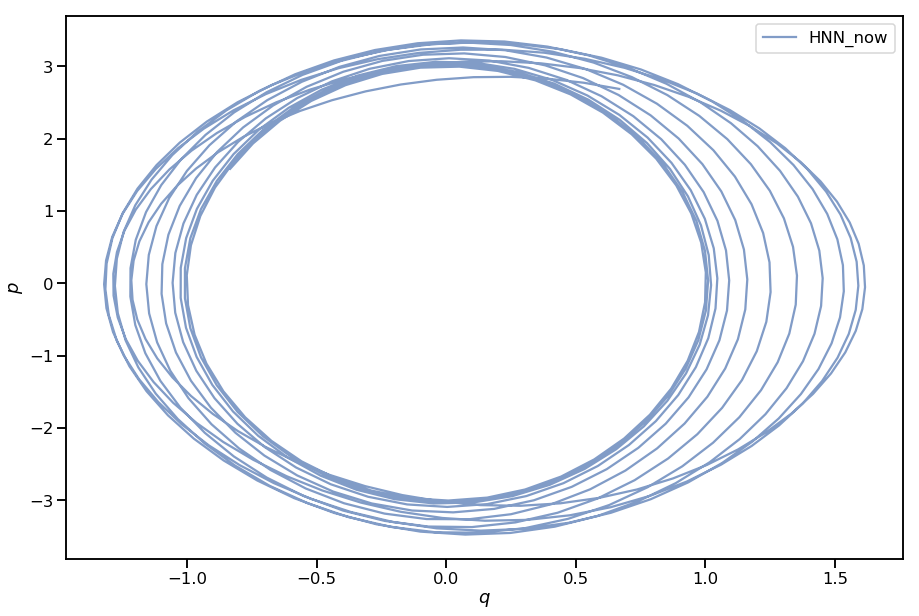

In [34]:
plt.figure(figsize=(15,10))
for key in model_results.keys():
    if key in ["HNN_VI","HNN_yoshida","HNN_symp_euler","HNN","HNN_dhdt_energy"]:
        continue
    preds = model_results[key][2]
    actual = model_results[key][3]
    plt.plot(preds[:,0],preds[:,1],label=key,alpha=0.7)
plt.legend(loc='best')
plt.xlabel(r'$q$')
plt.ylabel(r'$p$')

In [113]:
with open('model_results' + '.pkl', 'wb') as f:
    pickle.dump(model_results, f, pickle.HIGHEST_PROTOCOL)

In [112]:
import pickle

In [ ]:
# plt.figure()
    # plt.plot(loss_collater['train'], label='train')
    # plt.plot(loss_collater['valid'], label='valid')
    # plt.yscale('log')
    # plt.title(f'simple pendulum: ntrain_inits:{num_trajectories},ntest_inits:{n_test_traj},tmax:{T_max},dt:{dt}')
    # plt.legend()
    # plt.show()
    #
    #
    #
    # preds = []
    # pred_ham = []
    # qinit = q[0].reshape(1, -1)
    # for i in range(len(q_next)):
    #     next_step_pred = model.next_step(qinit,tevals[i])
    #     pred_ham.append(model.get_H(torch.cat([qinit,tevals[i].reshape(-1,1)],1)))
    #     preds.append(next_step_pred)
    #     qinit = next_step_pred
    #
    # pred_ham = torch.cat(pred_ham)
    #
    # plt.figure()
    # plt.scatter(range(len(q_next)),pred_ham.detach().numpy())
    # plt.show()
    #
    # preds = torch.cat(preds)
    # preds = preds.detach().numpy()
    # q_next = q_next.detach().numpy()
    #
    # plt.figure()
    # plt.scatter(range(len(preds)),np.mean(np.abs(preds-q_next),1))
    # plt.show()
    #
    #
    # print(np.mean((preds-q_next)**2))
    # plt.figure()
    # plt.plot(preds[:, 0], preds[:, 1], label='predicted')
    # plt.plot(q_next[:, 0], q_next[:, 1], label='true')
    # plt.scatter(preds[:, 0], preds[:, 1], label='predicted', s=3)
    # plt.scatter(q_next[:, 0], q_next[:, 1], label='true', s=3)
    # plt.legend()
    # plt.show()